In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Reshape
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest

df = pd.read_csv('/content/pamap2_HAR_raw.csv')
df=df.head(25000)
# Linear Interpolation, Feature Engineering and drop NANs
sensor_columns = [col for col in df.columns if col not in ['timestamp', 'activityID', 'activity_name']]
sensor_data = df[sensor_columns]
sensor_data = sensor_data.interpolate(method='linear', axis=0)
sensor_data = sensor_data.dropna()

sensor_data['hand_acc_magnitude'] = np.sqrt(
    sensor_data['IMU_hand_3D_acceleration_1']**2 +
    sensor_data['IMU_hand_3D_acceleration_2']**2 +
    sensor_data['IMU_hand_3D_acceleration_3']**2
)
sensor_data['chest_acc_magnitude'] = np.sqrt(
    sensor_data['IMU_chest_3D_acceleration_1']**2 +
    sensor_data['IMU_chest_3D_acceleration_2']**2 +
    sensor_data['IMU_chest_3D_acceleration_3']**2
)
sensor_data['chest_gyro_magnitude'] = np.sqrt(
    sensor_data['IMU_chest_3D_gyroscope_1']**2 +
    sensor_data['IMU_chest_3D_gyroscope_2']**2 +
    sensor_data['IMU_chest_3D_gyroscope_3']**2
)
sensor_data['chest_mag_magnitude'] = np.sqrt(
    sensor_data['IMU_chest_3D_magnetometer_1']**2 +
    sensor_data['IMU_chest_3D_magnetometer_2']**2 +
    sensor_data['IMU_chest_3D_magnetometer_3']**2
)
sensor_data['ankle_acc_magnitude'] = np.sqrt(
    sensor_data['IMU_ankle_3D_acceleration_1']**2 +
    sensor_data['IMU_ankle_3D_acceleration_2']**2 +
    sensor_data['IMU_ankle_3D_acceleration_3']**2
)
sensor_data['ankle_gyro_magnitude'] = np.sqrt(
    sensor_data['IMU_ankle_3D_gyroscope_1']**2 +
    sensor_data['IMU_ankle_3D_gyroscope_2']**2 +
    sensor_data['IMU_ankle_3D_gyroscope_3']**2
)
sensor_data['ankle_mag_magnitude'] = np.sqrt(
    sensor_data['IMU_ankle_3D_magnetometer_1']**2 +
    sensor_data['IMU_ankle_3D_magnetometer_2']**2 +
    sensor_data['IMU_ankle_3D_magnetometer_3']**2
)

# Drop original columns
cols_to_drop = [
    'IMU_chest_3D_acceleration_1', 'IMU_chest_3D_acceleration_2', 'IMU_chest_3D_acceleration_3',
    'IMU_hand_3D_acceleration_1', 'IMU_hand_3D_acceleration_2', 'IMU_hand_3D_acceleration_3',
    'IMU_chest_3D_gyroscope_1', 'IMU_chest_3D_gyroscope_2', 'IMU_chest_3D_gyroscope_3',
    'IMU_hand_3D_gyroscope_1', 'IMU_hand_3D_gyroscope_2', 'IMU_hand_3D_gyroscope_3',
    'IMU_chest_3D_magnetometer_1', 'IMU_chest_3D_magnetometer_2', 'IMU_chest_3D_magnetometer_3',
    'IMU_ankle_3D_acceleration_1', 'IMU_ankle_3D_acceleration_2', 'IMU_ankle_3D_acceleration_3',
    'IMU_ankle_3D_gyroscope_1', 'IMU_ankle_3D_gyroscope_2', 'IMU_ankle_3D_gyroscope_3',
    'IMU_ankle_3D_magnetometer_1', 'IMU_ankle_3D_magnetometer_2', 'IMU_ankle_3D_magnetometer_3'
]
sensor_data = sensor_data.drop(cols_to_drop, axis=1)

# Scale data
scaler = MinMaxScaler()
sensor_data_scaled = scaler.fit_transform(sensor_data)
sensor_data_scaled = pd.DataFrame(sensor_data_scaled, columns=sensor_data.columns)

# Reintroduce for splitting
sensor_data_scaled['timestamp'] = df['timestamp']
train_threshold = df['timestamp'].quantile(0.8)
train_data = sensor_data_scaled[sensor_data_scaled['timestamp'] < train_threshold].drop(columns=['timestamp'])
test_data = sensor_data_scaled[sensor_data_scaled['timestamp'] >= train_threshold].drop(columns=['timestamp'])

In [2]:
def create_sequences(data, seq_length=20):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data.iloc[i : i + seq_length].values)
    return np.array(sequences)

X_train = create_sequences(train_data)
X_test = create_sequences(test_data)

# LSTM AutoEncoder

In [5]:
class LSTMAutoencoder(Model):
    def __init__(self, input_shape):
        super(LSTMAutoencoder, self).__init__()
        self.encoder_lstm1 = LSTM(128, activation='relu', return_sequences=True)
        self.encoder_lstm2 = LSTM(64, activation='relu', return_sequences=False)
        self.decoder_repeat = RepeatVector(input_shape[0])
        self.decoder_lstm1 = LSTM(64, activation='relu', return_sequences=True)
        self.decoder_lstm2 = LSTM(128, activation='relu', return_sequences=True)
        self.decoder_dense = Dense(input_shape[1], activation='linear')
        self.reshape_layer = Reshape(input_shape)

    def call(self, inputs):
        x = self.encoder_lstm1(inputs)
        x = self.encoder_lstm2(x)
        x = self.decoder_repeat(x)
        x = self.decoder_lstm1(x)
        x = self.decoder_lstm2(x)
        x = self.decoder_dense(x)
        return self.reshape_layer(x)

seq_length = X_train.shape[1]
num_features = X_train.shape[2]
autoencoder = LSTMAutoencoder((seq_length, num_features))
autoencoder.compile(optimizer='adam', loss='mse')

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - loss: 1.3507e-04
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - loss: 1.1314e-04
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - loss: 1.1373e-04
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 87ms/step - loss: 1.1446e-04
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - loss: 1.1249e-04
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 87ms/step - loss: 1.1694e-04
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - loss: 1.1434e-04
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 86ms/step - loss: 1.0100e-04
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - loss: 1.1214e-04
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 87s 96ms/step - loss: 9.5995e-05


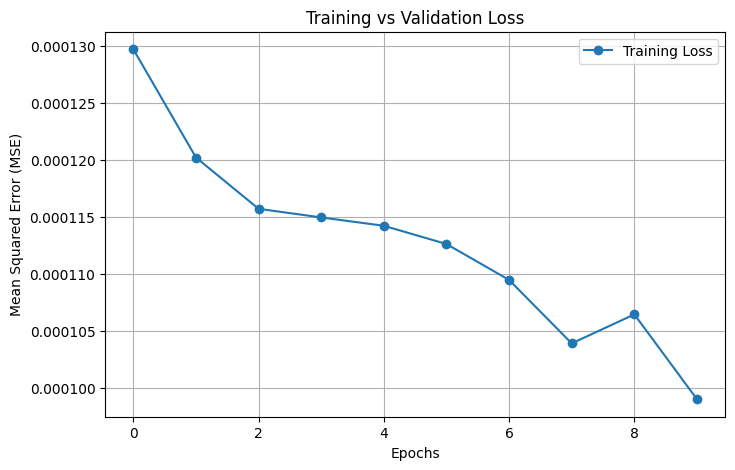

In [12]:
history=autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, shuffle=True, verbose=1)
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [13]:
def compute_reconstruction_errors(X):
    reconstructed = autoencoder.predict(X)
    return np.mean(np.abs(X - reconstructed), axis=(1, 2))

train_errors = compute_reconstruction_errors(X_train)
test_errors = compute_reconstruction_errors(X_test)


625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step


# Feedback Isolation Forest (FiF)

In [14]:

class FeedbackIsolationForest:
    def __init__(self, n_estimators=100, contamination=0.05):
        self.iforest = IsolationForest(n_estimators=n_estimators, contamination=contamination)

    def fit(self, data, feedback=None):
        if feedback is not None:
            normal_idx = np.where(feedback == 0)[0]
            data = data[normal_idx]
        self.iforest.fit(data.reshape(-1, 1))

    def predict(self, data):
        return self.iforest.predict(data.reshape(-1, 1))

fif = FeedbackIsolationForest()
fif.fit(train_errors)

predictions_test = fif.predict(test_errors)
pred_labels_test = np.where(predictions_test == -1, 1, 0)

threshold = np.percentile(train_errors, 95) # 95th percentile
true_anomaly = np.where(test_errors > threshold, 1, 0)

accuracy = np.mean(pred_labels_test == true_anomaly)
print(f"FIF-based Anomaly Detection Accuracy: {accuracy:.4f}")

FIF-based Anomaly Detection Accuracy: 1.0000


156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step


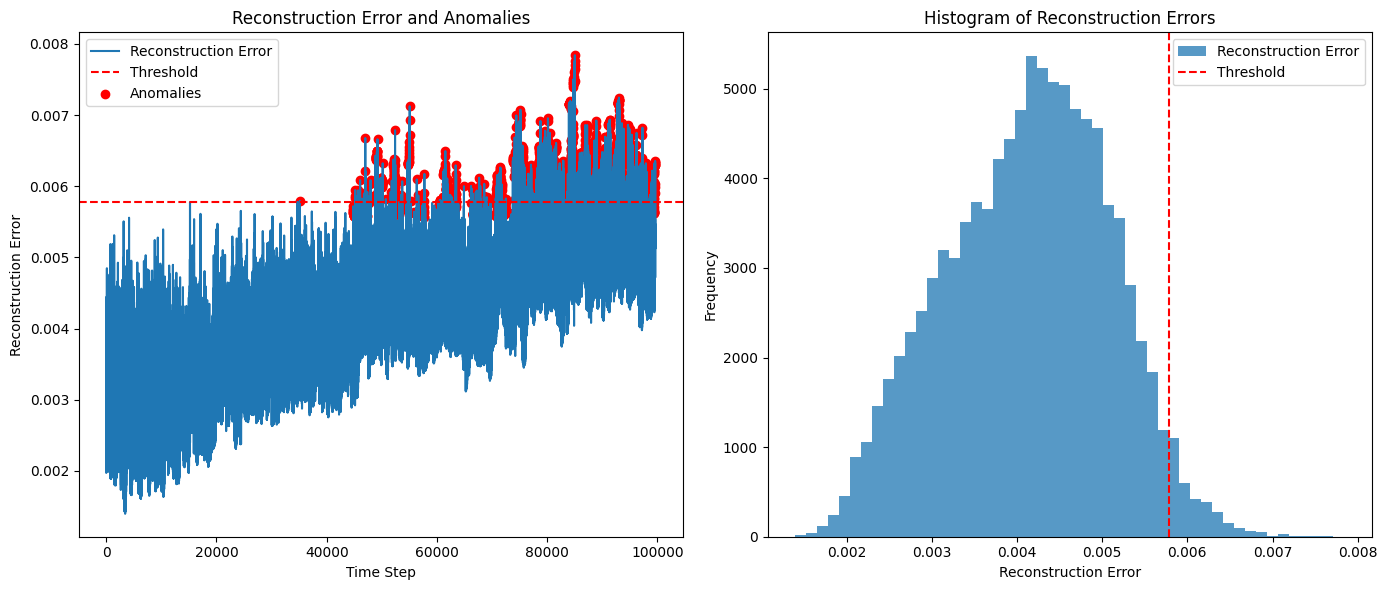

Total number of anomalies detected: 4980
Indices of anomalous points: [35120 44799 44818 ... 99560 99570 99589]
Reconstruction errors of anomalous points: [0.00579443 0.00571953 0.005681   ... 0.00590721 0.00632427 0.0063563 ]


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

reconstructed_test = autoencoder.predict(X_test)
reconstruction_error_test = np.mean(np.abs(X_test - reconstructed_test), axis=2)
threshold = np.percentile(reconstruction_error_test, 95, axis=0, keepdims=True)

anomalies = (reconstruction_error_test > threshold).astype(int)
total_anomalies = np.sum(anomalies)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(reconstruction_error_test.flatten(), label='Reconstruction Error')
plt.axhline(y=threshold.flatten()[0], color='r', linestyle='--', label='Threshold')
plt.scatter(np.where(anomalies.flatten() == 1), reconstruction_error_test.flatten()[anomalies.flatten() == 1], color='r', label='Anomalies')
plt.xlabel('Time Step')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error and Anomalies')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(reconstruction_error_test.flatten(), bins=50, alpha=0.75, label='Reconstruction Error')
plt.axvline(x=threshold.flatten()[0], color='r', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Errors')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Total number of anomalies detected: {total_anomalies}")

anomalous_points = np.where(anomalies.flatten() == 1)[0]
print("Indices of anomalous points:", anomalous_points)
print("Reconstruction errors of anomalous points:", reconstruction_error_test.flatten()[anomalous_points])